In [1]:
from src.codeGameSimulation.GameUr import GameUr, Player, Dice, GameSettings
import gameBoardDisplay as gbd

from fractions import Fraction

import locale

import numpy as np

from helpers import colorboxplot, makeVlines, zeichneErrechnetenWert, drawGame, colors
from src.codeGameSimulation.store2db import getDataFromDB, getGameFromDB, getGSFromDB

# %config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import matplotlib.axes as axes

locale.setlocale(locale.LC_NUMERIC, "german")

mplstyle.use("fast")
mplstyle.use("default")
# mpl.rcParams['figure.figsize'] = [20, 10]
import sqlite3


In [2]:
db_dir = "D:/Uni/BA/data/"
db_filename = "gameHistories_baseline_two_players"


In [3]:
ids,roundCounts, stepCounts, winners, settingsIDs = getDataFromDB(db_dir, db_filename)
gs_unordered = getGSFromDB(db_dir,db_filename)
print([len(id) for id in ids])

db load finished after 0:00:00.009003
sort finished after 0:00:00.001000
groupby finished after 0:00:00
sort finished after 0:00:00.001000
split finished after 0:00:00.004000
settings loaded
[1500]


In [4]:
labels_unordered = [" vs ".join([p.getStrategy().getName(
)+" [{}]".format(p.getStoneCount()) for p in gs_.getPlayers()]) for gs_ in gs_unordered]
labels = [labels_unordered[i] for i in settingsIDs]
gameSettings = [gs_unordered[i] for i in settingsIDs]
labels



['random [7] vs random [7]']

7


Text(0.5, 0, 'empirisch bestimmte Spiellänge in Runden')

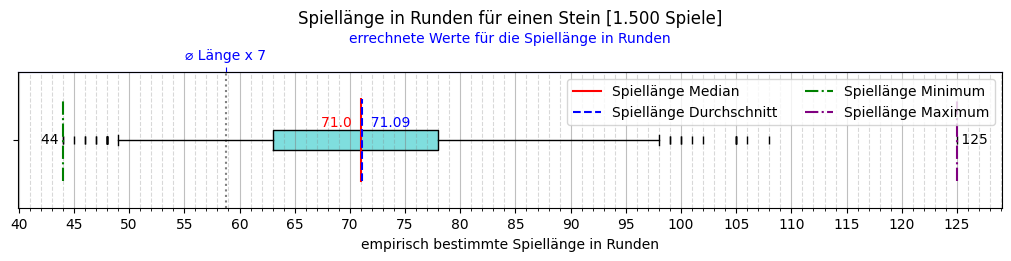

In [5]:
rc = roundCounts[0]
figRounds7s, ax = plt.subplot_mosaic([["Boxplots Runden"]], figsize=[
    10, 2.5], layout="constrained")
# ax2 = plt.twinx(ax["Boxplots Runden"])
# makeHistogram(ax2,[rc],[""],colors[0],fill=False)
# ax2.set_ylabel("Wahrschenlichkeit")
zeichneErrechnetenWert(ax["Boxplots Runden"], "r",7)

colorboxplot([rc], ax["Boxplots Runden"], [""], colors[0])
ax["Boxplots Runden"].set_title(
    "Spiellänge in Runden für einen Stein [{0:n} Spiele]".format(len(rc), grouping=True))
ax["Boxplots Runden"].set_xlabel('empirisch bestimmte Spiellänge in Runden')


In [6]:
rc = roundCounts[0]
roundInfo={"⌀": np.mean(rc), "min": np.min(rc), "max": np.max(rc),
 "p1": np.percentile(rc, 1),
 "p25": np.percentile(rc, 25),
 "p50": np.percentile(rc, 50),
 "p75": np.percentile(rc, 75),
 "p99": np.percentile(rc, 99),
 "min_count": rc.count(np.min(rc)),
 "max_count": rc.count(np.max(rc)),
 }
roundInfo


{'⌀': 71.08933333333333,
 'min': 44,
 'max': 125,
 'p1': 49.0,
 'p25': 63.0,
 'p50': 71.0,
 'p75': 78.0,
 'p99': 98.0,
 'min_count': 2,
 'max_count': 1}

### Schritte

7


Text(0.5, 1.0, 'Spiellänge in Schritten für sieben Steine [1.500 Spiele]')

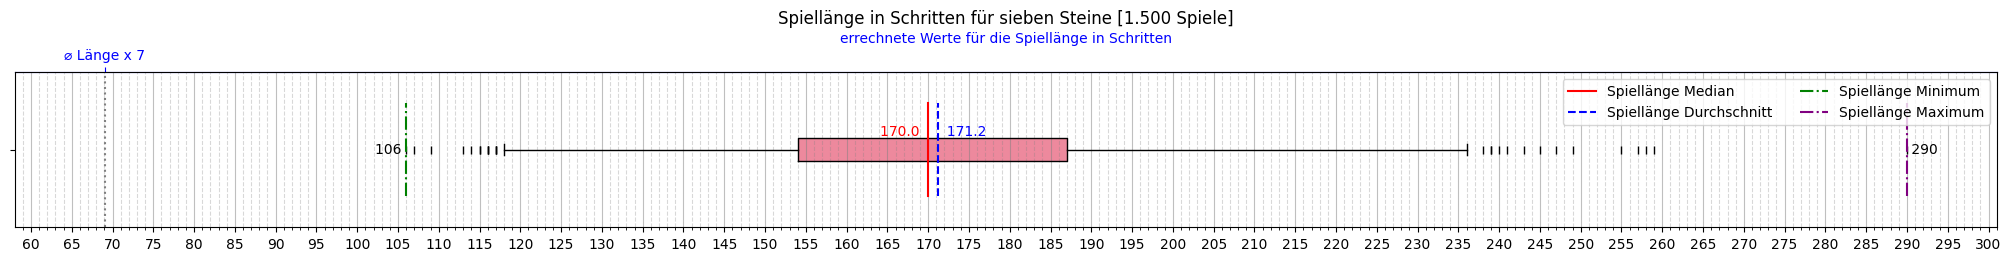

In [7]:
sc = stepCounts[0]
figSteps7s, ax = plt.subplot_mosaic([["Boxplots Schritte"]], figsize=[
    20, 2.5], layout="constrained")
zeichneErrechnetenWert(ax["Boxplots Schritte"], "s", 7)
colorboxplot([sc], ax["Boxplots Schritte"], [""], [colors[0]])
ax["Boxplots Schritte"].set_title(
    "Spiellänge in Schritten für sieben Steine [{0:n} Spiele]".format(len(sc), grouping=True))


## typischer Spielverlauf

ID für Spiel mit durchschnittlicher Länge: 30
Daten geladen


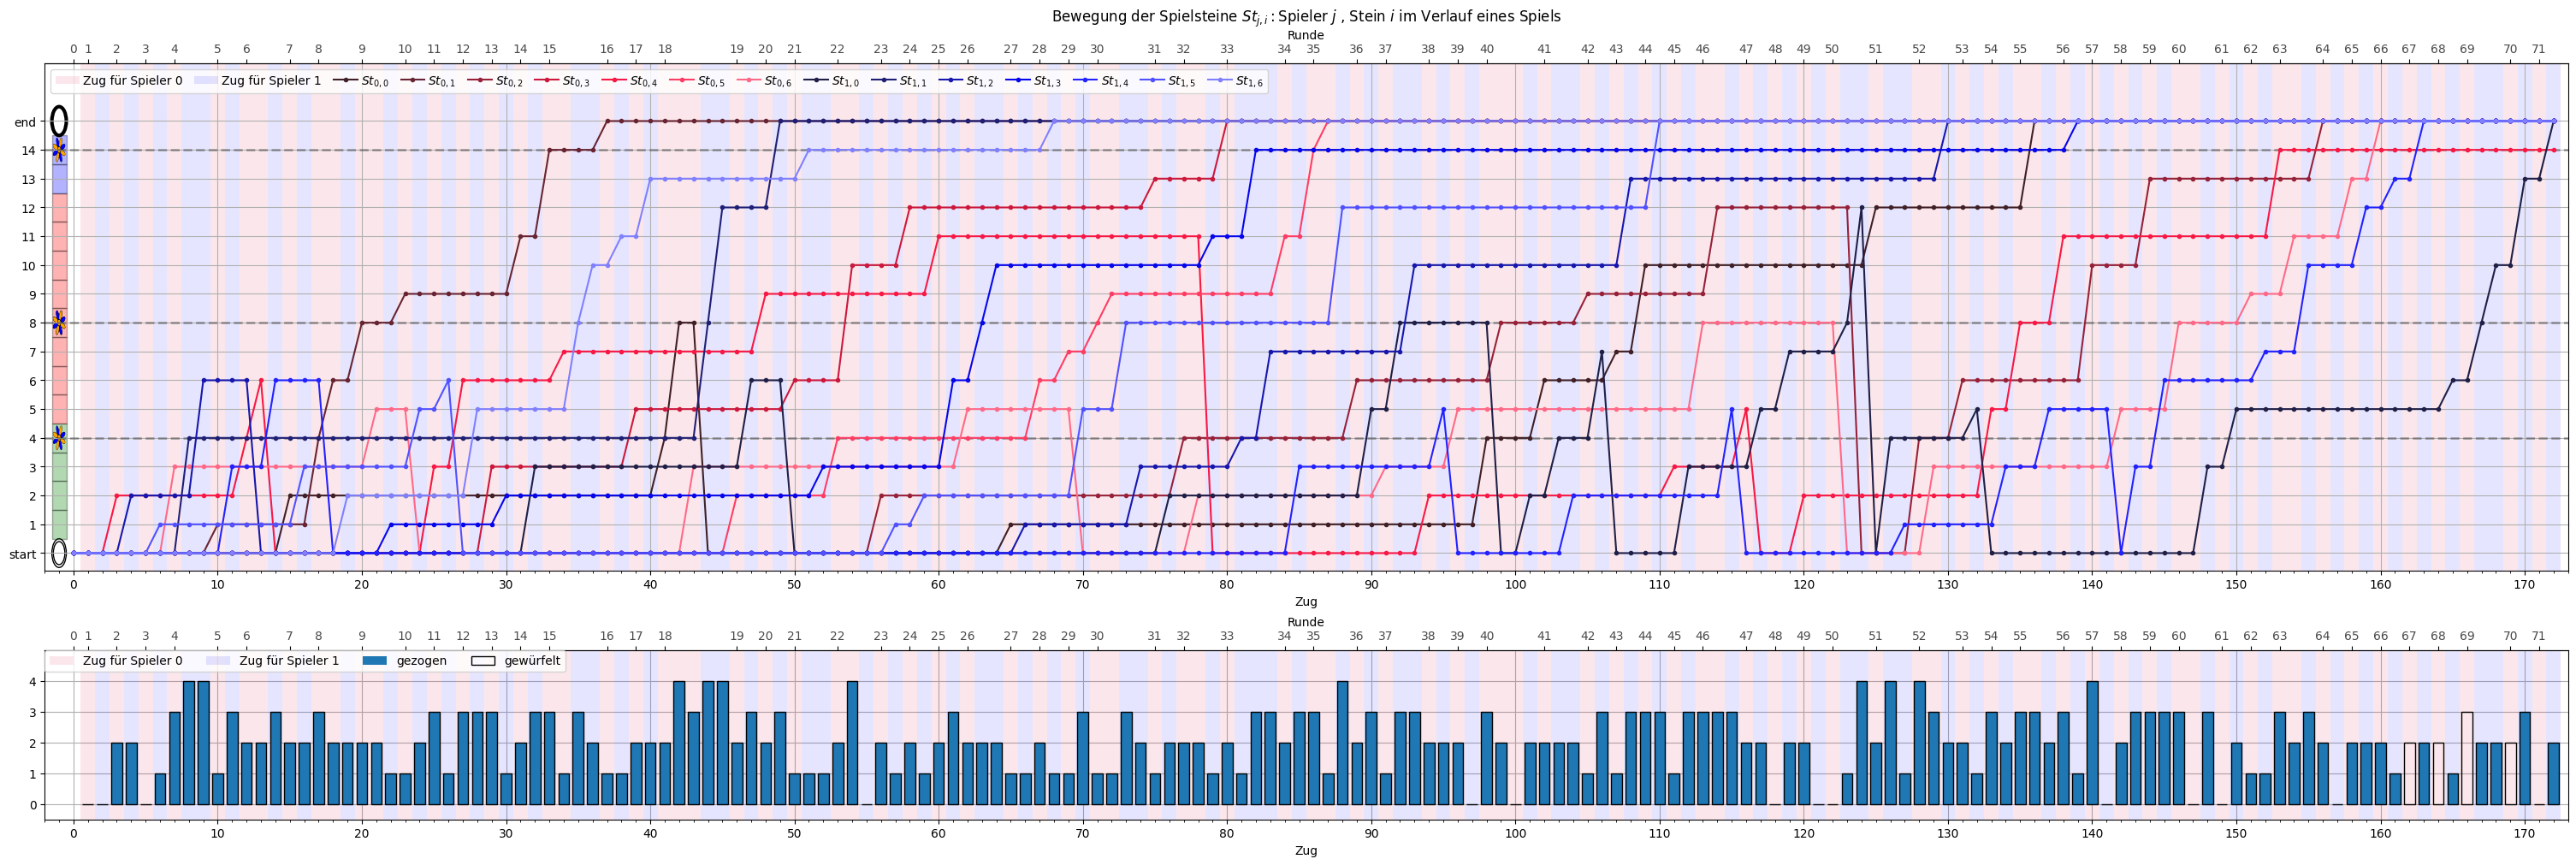

In [8]:
gameIDAvg = rc.index(int(np.round(roundInfo["⌀"])))

print("ID für Spiel mit durchschnittlicher Länge:", ids[0][gameIDAvg])
gameAvg = getGameFromDB(ids[0][gameIDAvg], db_dir, db_filename)
print("Daten geladen")
figMovement = drawGame(gameAvg, gameSettings[0])


## Histogramm

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


showDiceRoll finish
color steps finish


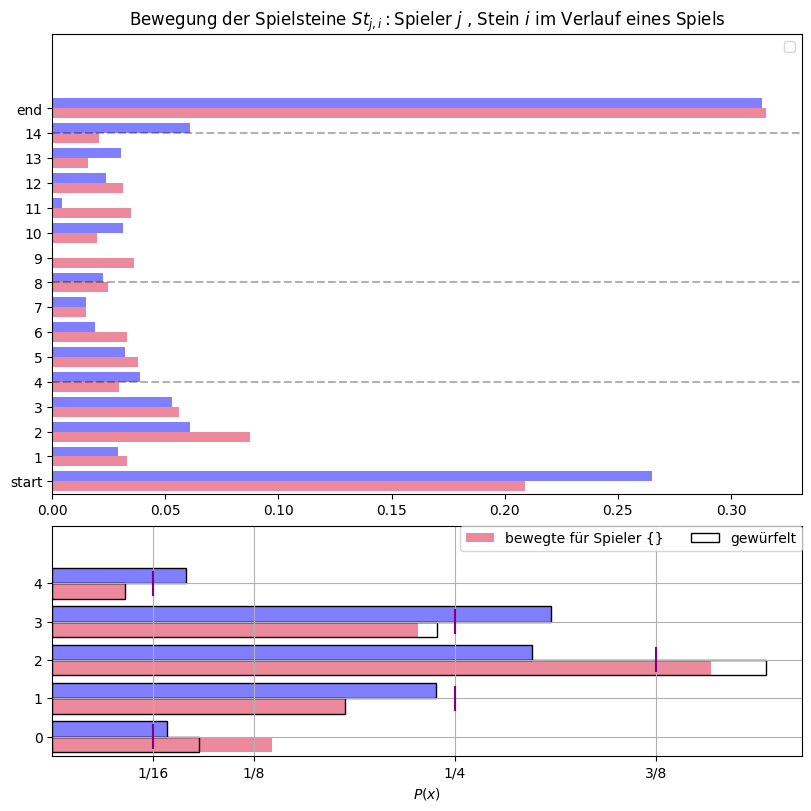

In [9]:
def drawGameHisto(db_row: sqlite3.Row, gs: GameSettings, showDiceRoll=True):
    width_ratios = [15]
    height_ratios = [2]
    mosaic = [["game_hist"]]
    if showDiceRoll:
        mosaic.append(["dice_hist"])
        height_ratios.append(1)
    

    figMovementHist, ax_dict = plt.subplot_mosaic(mosaic, figsize=[8,8],
                                              gridspec_kw={'height_ratios': height_ratios, 'width_ratios': width_ratios}, layout="constrained")

    ax_game: axes.Axes = ax_dict["game_hist"]
    ax_game.set_yticks(range(0, 16), ["start"]+list(range(1, 15))+["end"])
    ax_game.set_ybound(-.5, 18)
    ax_game.set_ylim(-.5, 18)

    for drf in gs.getDoubleRollFields():
        ax_game.axhline(drf, color=(0, 0, 0, 0.3),  ls='--')

    ax_game.hist([np.asarray(list(gameAvg["stones"][p].values())).flatten() for p in db_row["stones"]], bins=np.arange(-.5, 17.5,1),
                 orientation="horizontal", align="mid", histtype="bar", density=True, color=colors[:len(db_row["stones"])], alpha=.5)


    ax_game.legend(ncol=14, handletextpad=.3, columnspacing=1)
    ax_game.set_title("Bewegung der Spielsteine $St_{j,i}:$Spieler $j$ , Stein $i$ im Verlauf eines Spiels")


    if showDiceRoll:
        ax_dice = ax_dict["dice_hist"]
        ax_dice.set_ybound(-.5, 5.5)
        ax_dice.set_ylim(-.5, 5.5)
        ax_dice.set_yticks(range(0, 5), list(range(0, 5)))

        player_names = [p.getName() for p in gs.getPlayers()]


        md = [[], []]
        dr = [[], []]
        for i, m in enumerate(db_row["moveDist"]):
            p = db_row["activePlayer"][0:][i]
            if p in player_names:
                md[player_names.index(p)].append(m)
                dr[player_names.index(p)].append(db_row["diceRoll"][i])

        # M4D0 = [0]+[1]*4+[2]*6+[3]*4+[4]*1
        # ax_dice.hist(M4D0, bins=np.arange(-0.5, 5.5, 1), orientation="horizontal", align="mid", histtype="bar",rwidth=.8, density=True,edgecolor='green', color=["none"], label="Wahrscheinlichkeitsverteilung Würfel",lw=2)
        
        ax_dice.hist(md, bins=np.arange(-0.5, 5.5, 1), orientation="horizontal", align="mid", histtype="bar", density=True, label=["bewegte für Spieler {}"], color=colors[:len(db_row["stones"])], alpha=.5)
        ax_dice.hist(dr, bins=np.arange(-0.5, 5.5, 1), orientation="horizontal", align="mid", histtype="bar", density=True, edgecolor='black', color=["none"]*len(player_names), label="gewürfelt")
        
        ax_dice.legend(borderaxespad=0.,ncol=2)

        makeVlines(ax_dice,[1/16,1/4,3/8,1/4,1/16,0],[0,1,2,3,4,5],"-",["purple"]*5+["none"])
        xticks = [1/16,1/8, 1/4, 3/8]
        ax_dice.set_xticks(xticks, [Fraction(item).limit_denominator() for item in xticks])
        ax_dice.set(xlabel=r'$P (x)$')
        ax_dice.grid()


    print("showDiceRoll finish")
    

    print("color steps finish")

drawGameHisto(gameAvg,gameSettings[0])

## Speichern der Grafiken

In [10]:
figMovement.savefig( "../../tex/game_ur_ba_thesis/img/Grafiken/Spielverlauf_Random_vs_Random.png", dpi=300,)